In [2]:
import numpy as np
import pandas as pd
import os
from pathlib import Path
from keras.preprocessing import image
import matplotlib.pyplot as plt
import pickle

import warnings
warnings.filterwarnings(action='ignore')

import seaborn as sns
sns.set_style('whitegrid')

In [3]:
#đọc dữ liệu hình ảnh, chuyển đổi
p = Path("Train/")
dirs = p.glob("*")
labels_dict = {'cat':0,'dog':1,'sheep':2 }

image_data = [] 
labels = []
for folder_dir in dirs:
    #print(str(folder_dir))
    label = str(folder_dir).split("\\")[-1][:-1]
    print("doc anh thanh cong thu muc Train:",label)
    for img_path in folder_dir.glob("*"):
        img = image.load_img(img_path, target_size=(32,32))
        img_array = image.img_to_array(img)
        image_data.append(img_array)
        labels.append(labels_dict[label])
#đọc dữ liệu cho test
p_test = Path("Test/")
dirs_test = p_test.glob("*")
labels_dict_test = {'cat':0,'dog':1,'sheep':2 }
image_data_test = []
labels_test = []
for folder_dir in dirs_test:
    #print(str(folder_dir))
    label = str(folder_dir).split("\\")[-1][:-1]
    print("doc anh thanh cong thu muc Test:",label)
    for img_path in folder_dir.glob("*"):
        img = image.load_img(img_path, target_size=(32,32))
        img_array = image.img_to_array(img)
        image_data_test.append(img_array)
        labels_test.append(labels_dict[label])
#train
print("image_data train",len(image_data))
print("Labels train",len(labels))
#test
print("image_data test",len(image_data_test))
print("Labels test",len(labels_test))

doc anh thanh cong thu muc Train: cat
doc anh thanh cong thu muc Train: dog
doc anh thanh cong thu muc Train: sheep
doc anh thanh cong thu muc Test: cat
doc anh thanh cong thu muc Test: dog
doc anh thanh cong thu muc Test: sheep
image_data train 3001
Labels train 3001
image_data test 600
Labels test 600


In [4]:
## Chuyển đổi dữ liệu thành mảng numpy train
image_data = np.array(image_data, dtype='float32')/255.0
labels = np.array(labels)
print(image_data.shape, labels.shape)
#print(type(image_data))
#print(type(labels))
## Chuyển đổi dữ liệu thành mảng numpy train
image_data_test = np.array(image_data_test, dtype='float32')/255.0
labels_test = np.array(labels_test)
print(image_data_test.shape, labels_test.shape)



(3001, 32, 32, 3) (3001,)
(600, 32, 32, 3) (600,)


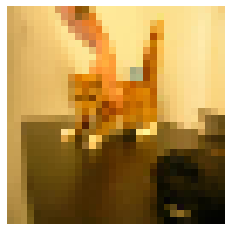

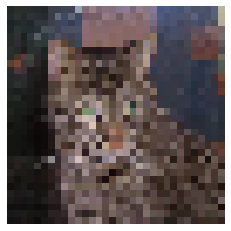

In [5]:
#in vài ảnh

def drawImg(img):
    plt.imshow(img)
    plt.axis('off')
    plt.show()


for i in range(2):
    drawImg(image_data[i])

<AxesSubplot:xlabel='label', ylabel='count'>

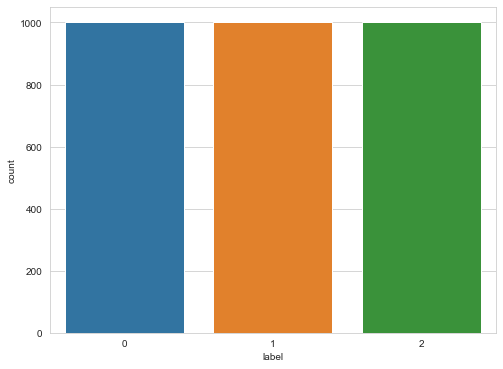

In [6]:
#so sanh dữ liệu train
df_labels = pd.DataFrame(
    labels,
    columns=['label']
)
plt.figure(figsize=(8, 6))
sns.countplot(data=df_labels, x='label')

In [7]:
class SVM:
    def __init__(self,C=1.0):
        self.C = C
        self.W = 0
        self.b = 0
   #  soft margin và  hard margin
    def hingeLoss(self,W,b,X,Y):
        loss  = 0.0
        loss += 0.5*np.dot(W,W.T) #T chuyển vị 
        m = X.shape[0] # số dòng dữ liệu mẫu
        for i in range(m):
            ti = Y[i]*(np.dot(W,X[i].T)+b)
            loss += self.C *max(0,(1-ti))

        return loss[0][0]

    def fit(self,X,Y,batch_size=50,learning_rate=0.001,maxItr=500):

        no_of_features = X.shape[1]
        no_of_samples = X.shape[0]
        print(no_of_samples)

        n = learning_rate
        c = self.C
        #khởi tạo các tham số mô hình
        W = np.zeros((1,no_of_features))
        bias = 0
        #Mất mát ban đầu
        #Training from here...
        # Weight and Bias cập nhật
        losses = []

        for i in range(maxItr):
            #Vòng lặp đào tạo

            l = self.hingeLoss(W,bias,X,Y) #mất mát
            losses.append(l)
            ids = np.arange(no_of_samples)
            np.random.shuffle(ids) #xáo trộn các giá trị mảng

            #Mini-Batch Gradient Descent với random shuffling
            for batch_start in range(0,no_of_samples,batch_size):
                #Assume 0 gradient for the batch
                gradw = 0
                gradb = 0

                #với 1 mini batch gồm 50 dòng dữ liệu
                for j in range(batch_start,batch_start+batch_size):
                    if j<no_of_samples:
                        i = ids[j]
                        ti =  Y[i]*(np.dot(W,X[i].T)+bias)

                        if ti>1:
                            gradw += 0
                            gradb += 0
                        else:
                            gradw += c*Y[i]*X[i]
                            gradb += c*Y[i]

                #Update W,B
                W = W - n*W + n*gradw
                bias = bias + n*gradb
        self.W = W
        self.b = bias
        return W,bias,losses

In [8]:
print(image_data.shape)
print(type(image_data.shape))

(3001, 32, 32, 3)
<class 'tuple'>


In [9]:
## Chuyển đổi dữ liệu cho phân loại Một vs Một 

M = image_data.shape[0]
image_data = image_data.reshape(M,-1)

print(image_data.shape)
print(type(image_data.shape))
print(labels.shape)

#test
M1 = image_data_test.shape[0]
image_data_test = image_data_test.reshape(M1,-1)

(3001, 3072)
<class 'tuple'>
(3001,)


In [10]:
number_of_classes = len(np.unique(labels))

In [11]:
#tạo Dictionary với key là label, là 0,1,2,3 và value là toàn bộ mảng Xi -> label đó
def classWiseData(x, y):
    data = {}

    for i in range(number_of_classes):
        data[i] = []

    for i in range(x.shape[0]):
        data[y[i]].append(x[i])

    for k in data.keys():
        data[k] = np.array(data[k])

    return data

In [12]:
data = classWiseData(image_data, labels)
print(type(data))

print(data[0].shape[0])
print(data[1].shape[0])
print(data[2].shape[0])
#print(data[3].shape[0])

<class 'dict'>
1000
1001
1000


In [13]:
#Kết hợp dữ liệu của hai lớp thành một ma trận duy nhất X,y 
def getDataPairForSVM(d1,d2):

    l1,l2 = d1.shape[0], d2.shape[0]
    samples = l1+l2
    features = d1.shape[1]
    #tạo một mảng với số dòng bằng dòng = 2 tập dữ liệu cộng lại
    #cột bằng số tính năng, đặc điểm của tập dữ liệu,vì 2 tập có số tính năng là
    #như nhau nên chỉ cần lấy độ lớn của 1 tập
    data_pair = np.zeros((samples,features))
    data_labels = np.zeros((samples,))

    data_pair[:l1,:] = d1
    data_pair[l1:,:] = d2

    data_labels[:l1] = -1
    data_labels[l1:] = 1

    return data_pair, data_labels

In [14]:
#Training SVM
mySVM = SVM()


In [15]:
# với one vs one (NumClasses * (NumClasses – 1)) / 2 = (4*(4-1)/2= 6 cặp
def trainSVMs(x,y):
    svm_classifiers = {}

    for i in range(number_of_classes):
        svm_classifiers[i] = {}
        for j in range(i+1, number_of_classes):
            print("data[",i,"] và data[",j,"]")
            xpair,ypair = getDataPairForSVM(data[i],data[j])
            wts,b,loss = mySVM.fit(xpair, ypair,learning_rate=0.00001,maxItr=1500)
            svm_classifiers[i][j] = (wts,b)
            name_plot = "plot_loss_"+str(i)+"-"+str(j)
            plt.plot(loss)
            plt.savefig("imagemodels/"+name_plot,dpi=150)
            plt.show()

    return svm_classifiers

data[ 0 ] và data[ 1 ]
2001


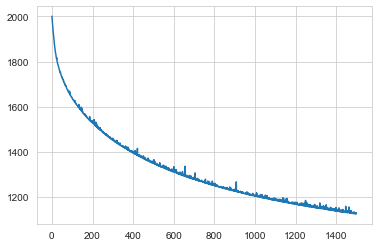

data[ 0 ] và data[ 2 ]
2000


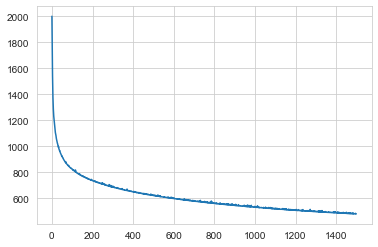

data[ 1 ] và data[ 2 ]
2001


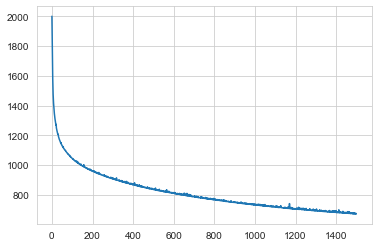

In [16]:
svm_classifiers = trainSVMs(image_data, labels)

pickle.dump(svm_classifiers,open("models/svm_build.pkl","wb"))

In [17]:
cats_dogs = svm_classifiers[0][1]
#cats_humans = svm_classifiers[0][3]
print("kích thước mảng tham số cho cat dog",cats_dogs[0].shape)
print("bias cho cat dog",cats_dogs[1])

kích thước mảng tham số cho cat dog (1, 3072)
bias cho cat dog -0.014879999999999808


In [18]:
#Prediction
def binaryPredict(x,w,b):
    z = np.dot(x,w.T) + b
    if z >= 0:
        return 1
    else:
        return -1

def predict(x):
    count = np.zeros((number_of_classes,)) #cat dog 1 
    for i in range(number_of_classes):
        for j in range(i+1, number_of_classes):
            w,b = svm_classifiers[i][j]
            #
            z = binaryPredict(x,w,b)
            #(lớp có tổng điểm lớn nhất) được dự đoán là nhãn lớp.
            if z==1:
                count[j] += 1
            else:
                count[i] += 1

    final_prediction = np.argmax(count)
    return final_prediction

(3072,)
[0.14117648 0.15686275 0.16862746 ... 0.19215687 0.13333334 0.11372549]
dự đoán: cat
thực tế: cat


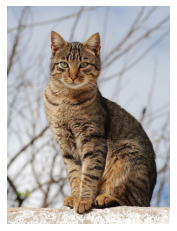

1
dự đoán: dog


In [19]:
pre = predict(image_data[500])
print(image_data[500].shape)
print(image_data[1])

switcher = {
    0: "cat",
    1: "dog",
    2: "sheep"

}

#dự đoán ảnh có sẵn trong tập huấn luyện
print("dự đoán:",switcher.get(pre, "nothing"))
t = labels[500]
print("thực tế:",switcher.get(t, "nothing"))
#dự đoán các ảnh khác
imgshow = image.load_img("imgthucte/cat2.jpg")
plt.imshow(imgshow)
plt.axis('off')
plt.show()
imgpre = image.load_img("imgthucte/cat2.jpg", target_size=(32,32))
imgpre_array = image.img_to_array(imgpre)
imgpre_array = np.array(imgpre_array, dtype='float32')/255.0
imgpre_array = imgpre_array.reshape(-1,)

pre1 = predict(imgpre_array)
print(pre1)
print("dự đoán:",switcher.get(pre1, "nothing"))

In [20]:
def accuracy(x,y):
    pred = []
    count=0
    for i in range(x.shape[0]):
        prediction = predict(x[i])
        pred.append(prediction)
        if prediction==y[i]:
            count += 1
    return count/x.shape[0], pred

In [21]:
acc, ypred = accuracy(image_data_test, labels_test)
print("chất lượng của hàm dự đoán tự viết: ",acc)

chất lượng của hàm dự đoán tự viết:  0.5566666666666666


In [22]:
#Using scikit
from sklearn import svm
svm_classifier = svm.SVC(kernel='linear', C=1.0, probability=True)
svm_classifier.fit(image_data, labels)
pickle.dump(svm_classifier,open("models/svm_sklearn.pkl","wb"))
type(image_data)

numpy.ndarray

In [23]:
ypred_sklearn = svm_classifier.predict(image_data_test)
print("chất lượng khi dùng thư viện Sklearn: ",svm_classifier.score(image_data_test,labels_test))

chất lượng khi dùng thư viện Sklearn:  0.5383333333333333


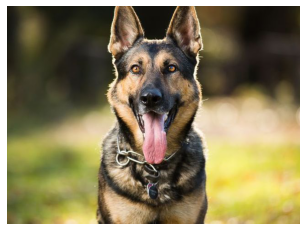

[2]
dự đoán: sheep


In [24]:
imgshow = image.load_img("imgthucte/dog2.jpg")
plt.imshow(imgshow)
plt.axis('off')
plt.show()
imgpre = image.load_img("imgthucte/dog2.jpg", target_size=(32,32))
imgpre_array = image.img_to_array(imgpre)
imgpre_array = np.array(imgpre_array, dtype='float32')/255.0
imgpre_array = imgpre_array.reshape(-1,)

pre2 = svm_classifier.predict([imgpre_array])
print(pre2)
print("dự đoán:",switcher.get(pre2[0], "nothing"))

SVM classifier


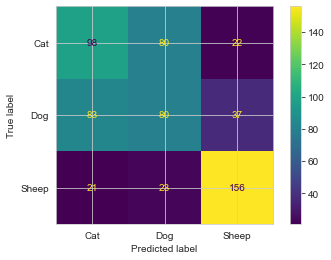

<Figure size 432x288 with 0 Axes>

In [31]:
#Ma trận nhầm lẫn- Confusion Matrix
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay, plot_confusion_matrix

class_names = ['Cat', 'Dog','Sheep']
print("SVM classifier")
cnf_matrix = confusion_matrix(labels_test, ypred)
disp = ConfusionMatrixDisplay(cnf_matrix,display_labels = class_names)
disp.plot()
plt.show()
#lưu hình ảnh để cho lên giao diện
plt.savefig("imagemodels\cfm_build.png",dpi=150)

Sci-kit Learn


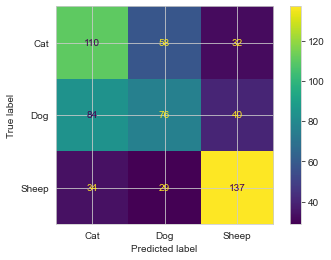

In [29]:
print("Sci-kit Learn")
plot_confusion_matrix(svm_classifier, image_data_test, labels_test, display_labels=class_names)
#lưu hình ảnh để cho lên giao diện
plt.savefig("imagemodels\cfm_sklearn.png",dpi=150)

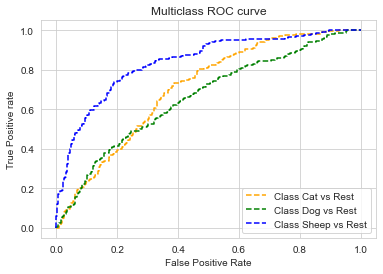

In [27]:
#đường cong ROC
from sklearn.metrics import roc_curve
pred_prob = svm_classifier.predict_proba(image_data_test)
fpr = {}
tpr = {}
thresh ={}

n_class = 3

for i in range(n_class):
    fpr[i], tpr[i], thresh[i] = roc_curve(labels_test, pred_prob[:,i], pos_label=i)

# plotting
plt.plot(fpr[0], tpr[0], linestyle='--',color='orange', label='Class Cat vs Rest')
plt.plot(fpr[1], tpr[1], linestyle='--',color='green', label='Class Dog vs Rest')
plt.plot(fpr[2], tpr[2], linestyle='--',color='blue', label='Class Sheep vs Rest')
plt.title('Multiclass ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')
plt.savefig('imagemodels\Multiclass ROC sklearn',dpi=300)
